### Overlapping Outcomes

In Chapter 3, label $y_i$ was assigned to observation feature $X_i$. Here, $y_i$ was a function of the price bars that occurred within the period $[t_{i,0}, t_{i, 1}]$. If $t_{i,1} > t_{j,0}$ and $i<j$, then both $y_i$ and $y_j$ depend on the common rate of return $r_{t_{j,0},\min\{t_{i,1}, t_{j,1}\}}$. That is, it is the rate of return in the interval $[t_{j,0},\min\{t_{i,1}, t_{j,1}\}]$. This implies that the series of labels $\{y_i\}-{i, \dots, I}$ is not an IID whenever there is an overlap in two consecutive $y_i$.

To solve this problem, let's consider limiting the betting period to $t_{i,1} \leq t_{i+1, 0}$. In this case, the output of all features is determined before or at the starting point of the next observation measurement, so no overlap occurs. This method will result in a crude model because the sampling frequency of the trait is limited by the time period used to determine the outcome. On the other hand, if you want to look at results that last for a month, features must be sampled on a monthly cycle. On the other hand, if the sampling frequency is increased by days, the period of output must be reduced to 1 day. Furthermore, when using time-dependent labeling techniques such as triple barrier, the sampling period will be dependent on the time of first reaching the barrier. In some cases, limiting the outcome horizon to eliminate concurrency is a poor solution. The case of $t_{i,1} > t_{i+1,0}$ must be allowed, and in this case, the concurrency problem explained previously occurs again.

This situation is a characteristic that appears when applying finance. Most non-financial machine learning researchers can assume that observations are derived from IID. For example, blood samples can be collected from many patients and then their cholesterol can be measured. Of course, the mean and standard deviation of the cholesterol distribution will vary due to various underlying common factors, but the samples are still independent. There is only one sample per subject. Imagine that someone in the lab tipped over this blood sample, causing the blood from each tube to spill into the nine tubes on the right. Tube number 10 contains the blood of patients 1 to 9 as well as the blood of patient 10, and tube 11 contains the blood of patients 2 to 10 along with patient 11. Now we need to find characteristics that can detect high cholesterol without knowing each patient's cholesterol level. This can be said to be the situation faced by financial machine learning. Not only are the pouring patterns different, but they are also well known. When it comes to financial machine learning applications, the plug and play approach does not apply. If you are listening to someone who says otherwise, you are most likely wasting your money and time.

There are several ways to deal with labels other than IIDs, and in Chapter 4, we solve this problem using sampling and weight design methods to correct the excessive influence of overlapping results.

### Number of Concurrent Labels

Two labels $y_i, y_j$ are said to coexist at time $t$ if they have **at least one** common return $r_{t-1, t} = \frac{p_t}{p_{t-1}} - 1$. This overlap does not require that the interval widths perfectly match each other in terms of time intervals. In this section, we calculate the number of labels that are a function of a given rate of return $r_{t-1, t}$.

1. At each time $t = 1, \dots, T$, construct a binary matrix ${1_{t,i}}_{i = 1,\dots, I}$, where $1_{t,i} \in \{0, 1\}$. The variable $1_{t,i}$ has a value of 1 only if $[t_{i,0}, t_{i,1}]$ and $[t-1, t]$ overlap, otherwise it is 0. Remember that the width of the label $\{[t_{i,0}, t_{i,1}]\}_{i=1,\dots,I}$ is defined in the `t1` object introduced in Chapter 3. 
2. Let’s calculate the number of concurrent labels at time $t, c_t = \sum_{i=1}^I 1_{t,i}$

$$c_t = \sum_{i=1}^I 1_{t,i}$$

The code below implements this logic.

In [2]:
# Setup path to import modules
import sys
from pathlib import Path

# Add the MLFinance root directory to Python path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # Go up from Notes/Week05Labeling to MLFinance
equity_ml_root = project_root.parent  # Go up to equity-ml-ldp

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"✓ Added {project_root} to Python path")
    
if str(equity_ml_root) not in sys.path:
    sys.path.insert(0, str(equity_ml_root))
    print(f"✓ Added {equity_ml_root} to Python path")

✓ Added /mnt/ssd_backup/equity-ml-ldp/MLFinance/Notes to Python path
✓ Added /mnt/ssd_backup/equity-ml-ldp/MLFinance to Python path


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from FinancialMachineLearning.sample_weights.concurrency import *
from FinancialMachineLearning.utils.multiprocess import *
from FinancialMachineLearning.labeling.labeling import *
from FinancialMachineLearning.features.volatility import daily_volatility

start_date = '2015-03-31'
end_date = '2025-09-29'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date,
    multi_level_index=False,
    auto_adjust=True
)

[*********************100%***********************]  1 of 1 completed


In [11]:
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Close'], 
    num_days = 15 # expariation limit
)
vertical_barrier.head()

Date
2015-03-31   2015-04-15
2015-04-01   2015-04-16
2015-04-02   2015-04-17
2015-04-06   2015-04-21
2015-04-07   2015-04-22
Name: Date, dtype: datetime64[ns]

In [12]:
volatility = daily_volatility(
    data['Close'], 
    lookback = 60 # moving average span
)

In [13]:
triple_barrier_events = get_events(
    close = data['Close'],
    t_events = data.index[2:],
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 1, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

,t1,trgt,pt,sl
Date,,,,
2015-04-08,2015-04-23,0.012751,2,1
2015-04-09,2015-04-23,0.010957,2,1
2015-04-10,2015-04-24,0.010326,2,1
2015-04-20,2015-04-27,0.011805,2,1
2015-04-21,2015-04-24,0.012102,2,1


In [14]:
labels = meta_labeling(
    triple_barrier_events, 
    data['Close']
)

In [15]:
labels.head()

,ret,trgt,bin
Date,,,
2015-04-08,0.032405,0.012751,1
2015-04-09,0.024573,0.010957,1
2015-04-10,0.025020,0.010326,1
2015-04-20,0.039577,0.011805,1
2015-04-21,0.026554,0.012102,1


In [16]:
labels['bin'].value_counts()

bin
 0    920
 1    904
-1    800
Name: count, dtype: int64

In [17]:
num_threads = 1
num_conc_events = mp_pandas_obj(
    concurrent_events, 
    ('molecule', triple_barrier_events.index), 
    num_threads, 
    close_series_index = data['Close'].index, 
    label_endtime = triple_barrier_events['t1']
)

In [31]:
num_conc_events = num_conc_events.reindex(data['Close'].index).fillna(0)

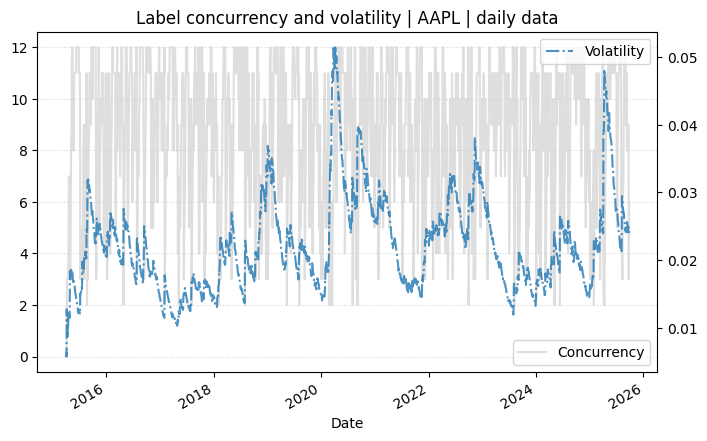

In [19]:
fig, ax = plt.subplots(figsize = (8, 5))
num_conc_events.plot(alpha = 0.75, color = 'lightgray', ax = ax)
plt.legend(['Concurrency'])

plt.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
    
volatility.plot(secondary_y = True, alpha = 0.8, ls = '-.', ax = ax)
plt.legend(['Volatility'])
plt.grid(False)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Label concurrency and volatility | AAPL | daily data')
plt.show()

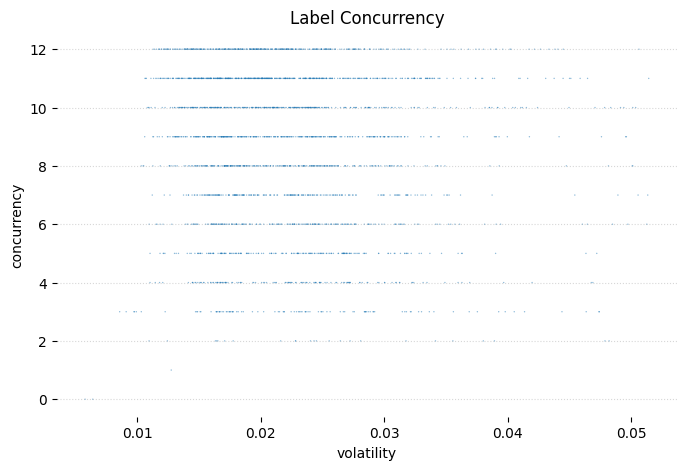

In [20]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.scatter(
    volatility[1:], num_conc_events[3:], 
    marker = '.', 
    alpha = 0.5, 
    edgecolor = 'none', 
    s = 4
)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('volatility')
plt.ylabel('concurrency')
plt.title('Label Concurrency')
plt.show()

### Average Uniqueness of a Label

In this section, we calculate the non-overlap (uniqueness) of the label as the average uniqueness over the entire cycle.

1. First, the eigenvalue of label $i$ at time $t$ is $u_{t,i} = 1_{t,i}^{-1}$. 
2. The average eigenvalue of label $i$ is the average $u_{t,i}$ during the label's cycle. 

$$\bar{u_i} = \left( \sum_{t=1}^T u_{t,i}\right) \left( \sum_{t=1}^T 1_{t,i}\right)^{-1}$$

This average eigendegree can also be interpreted as the reciprocal of the harmonic mean of $c_t$ over the period of the event. The figure below shows the eigenvalues ​​derived from object `t1` as a histogram.

In [30]:
avg_unique = mp_pandas_obj( # average uniqueness
    average_uniqueness, 
    ('molecule', triple_barrier_events.index), 
    num_threads, 
    label_endtime = triple_barrier_events['t1'], 
    num_conc_events = num_conc_events
)
avg_unique.head()

Date
2015-04-08    0.354960
2015-04-09    0.296320
2015-04-10    0.266017
2015-04-20    0.187698
2015-04-21    0.169048
dtype: float64

In [22]:
pd.DataFrame(avg_unique, columns = ['avg_unique']).to_parquet('avg_unique.parquet')

In [23]:
triple_barrier_events.to_parquet('AAPL_triple_barrier_events.parquet')

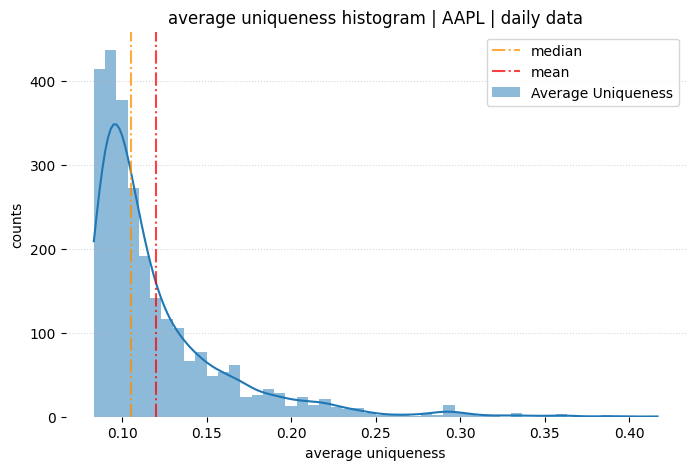

In [24]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (8, 5))
sns.histplot(
    avg_unique,
    bins = 50,
    edgecolor = 'none',
    kde = True,
    label = 'Average Uniqueness',
)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(
    avg_unique.median(), 
    color = 'darkorange', 
    alpha = 0.75, 
    ls = '-.', 
    label = 'median'
)
plt.axvline(
    avg_unique.mean(), 
    color = 'red', 
    alpha = 0.75,
    ls = '-.', 
    label = 'mean'
)
plt.legend()
plt.xlabel('average uniqueness')
plt.ylabel('counts')
plt.title('average uniqueness histogram | AAPL | daily data')
plt.show()

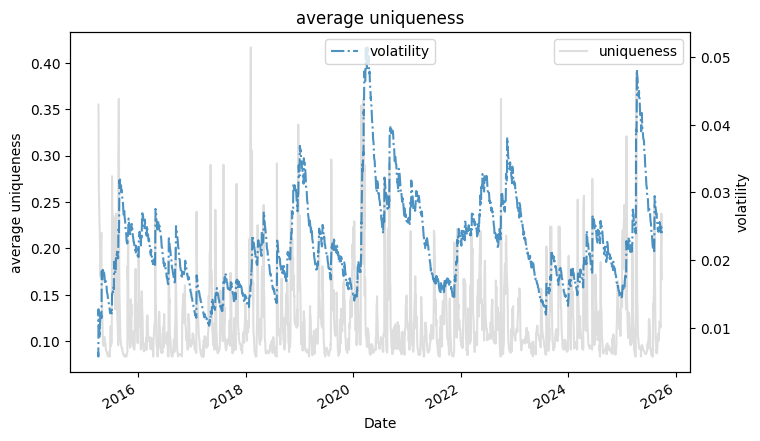

In [25]:
fig, ax = plt.subplots(figsize = (8, 5))
avg_unique.plot(alpha = 0.75, ax = ax, color = 'lightgray')
plt.legend(['uniqueness'])
plt.grid(False)
plt.ylabel('average uniqueness')

volatility.plot(secondary_y = True, alpha = 0.8, ax = ax, ls = '-.')
plt.legend(['volatility'], loc = 'upper center')
plt.grid(False)
plt.title('average uniqueness')
plt.xlabel('concurrency')
plt.ylabel('volatility')
plt.show()

label의 평균 고유도는 volatility와 대응되는 개념이므로, 시계열 메모리를 갖는 특성이 있다

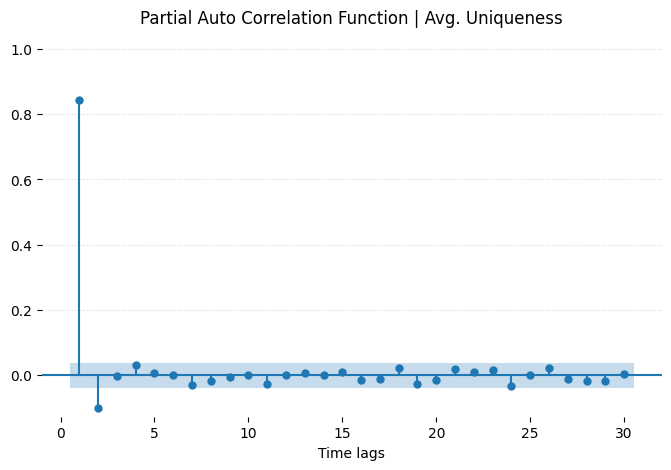

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(avg_unique, auto_ylims = True, lags = range(1, 31), ax = ax)
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial Auto Correlation Function | Avg. Uniqueness')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

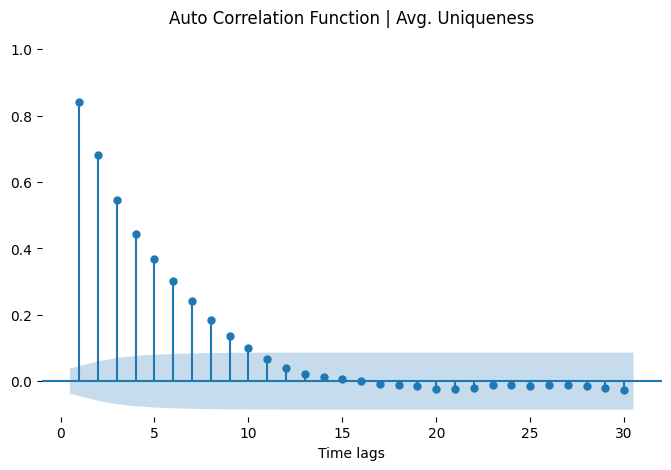

In [27]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(avg_unique, auto_ylims = True, lags = range(1, 31), ax = ax)
plt.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function | Avg. Uniqueness')
plt.show()

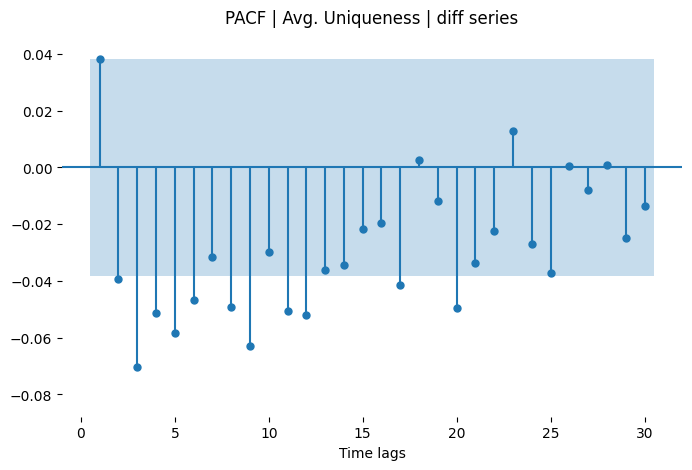

In [28]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(avg_unique.pct_change().dropna(), auto_ylims = True, lags = range(1, 31), ax = ax)
plt.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('PACF | Avg. Uniqueness | diff series')
plt.show()

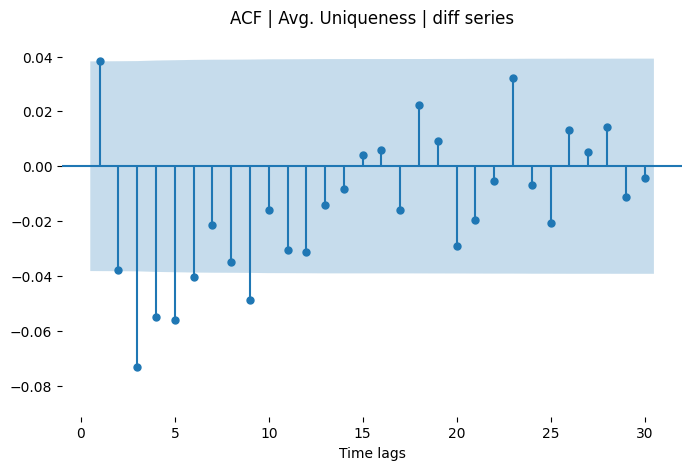

In [29]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(avg_unique.pct_change().dropna(), auto_ylims = True, lags = range(1, 31), ax = ax)
plt.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('ACF | Avg. Uniqueness | diff series')
plt.show()